In [1]:
# Install gdown (if not already installed)
#!pip install gdown --upgrade --quiet

# install OpenAI API
#!pip install openai

# install tiktoken to count tokens
#!pip install tiktoken

# install package to handle tiff files 
#!pip install tifffile

In [2]:
import io
import os
import re
import csv
import math
import base64
import hashlib
import tifffile
import tiktoken
import textwrap
import numpy as np
from PIL import Image
from openai import OpenAI
from matplotlib import pyplot as plt

In [3]:
def is_mostly_black(image, threshold=20):
    # Count the number of pixels below the black threshold
    black_pixels = np.sum(image < threshold)
    total_pixels = image.size

    # Compute the proportion of black pixels
    black_ratio = black_pixels / total_pixels

    # Determine if it exceeds 10% of the image
    is_mostly_black = black_ratio >= 0.1

    return is_mostly_black

def is_mostly_white(image, threshold=230):
    # Count the number of pixels above the white threshold
    white_pixels = np.sum(image > threshold)
    total_pixels = image.size

    # Compute the proportion of white pixels
    white_ratio = white_pixels / total_pixels

    # Determine if it exceeds 10% of the image
    is_mostly_white = white_ratio >= 0.6

    return is_mostly_white
    
# Function to hash image content
def hash_image(image_array):
    return hashlib.md5(image_array.tobytes()).hexdigest()

In [4]:
he_patches_dir = "../../../../../extra/zhanglab0/xil43/Xenium/CellNet_data/tissue_patch/tissue_img/"

image_dict = {}
dir_dict = {}

# Configs
max_files_per_dir = 20
max_dirs = 10
start_dir_idx = 20
end_dir_idx = start_dir_idx + max_dirs
dirs_to_visit = list(range(start_dir_idx, end_dir_idx))

MEAN_THRESHOLD = 225.0
STD_THRESHOLD = 1.0

if not os.path.exists(he_patches_dir):
    print(f"❌ Error: The directory '{he_patches_dir}' does not exist.")
    exit()

print("🧭 Target directory indices:", dirs_to_visit)

visited_dirs = set()
dir_index = 0
num_dirs = 0
total_files = 0

for intermediate_dir in os.listdir(he_patches_dir):
    intermediate_path = os.path.join(he_patches_dir, intermediate_dir)
    if not os.path.isdir(intermediate_path):
        continue

    for dir_name in os.listdir(intermediate_path):
        full_dir_path = os.path.join(intermediate_path, dir_name)
        if not os.path.isdir(full_dir_path):
            continue

        if dir_index not in dirs_to_visit:
            dir_index += 1
            continue

        if dir_name in visited_dirs or "mouse" in dir_name:
            print(f"⚠️ Skipping duplicate directory: {dir_name}")
            dir_index += 1
            continue

        visited_dirs.add(dir_name)
        dir_index += 1

        image_list = []
        image_hashes_in_dir = set()
        files_processed = 0

        for file in os.listdir(full_dir_path):
            if files_processed >= max_files_per_dir:
                break

            file_path = os.path.join(full_dir_path, file)
            file_ext = file.lower().split('.')[-1]

            try:
                if file_ext == "tif":
                    image = tifffile.imread(file_path)

                    if image.dtype != np.uint8:
                        image = np.clip(image, 0, 1) if image.dtype in [np.float32, np.float64] else image
                        image = (image * 255).astype(np.uint8) if image.dtype in [np.float32, np.float64] else \
                                (image / np.max(image) * 255).astype(np.uint8)

                    img_mean = np.mean(image)
                    img_std_dev = np.std(image)
                    #if img_mean > MEAN_THRESHOLD or img_std_dev < STD_THRESHOLD or is_mostly_black(image) or is_mostly_white(image):
                    if is_mostly_black(image) or is_mostly_white(image):
                        continue

                    img_hash = hash_image(image)
                    if img_hash in image_hashes_in_dir:
                        print(f"⚠️ Skipping duplicate image in directory: {file_path}")
                        continue
                    image_hashes_in_dir.add(img_hash)

                    new_file_path = file_path.replace(".tif", ".jpg")
                    Image.fromarray(image).convert("RGB").save(new_file_path, "JPEG")
                    image_list.append(new_file_path)
                    files_processed += 1
                    total_files += 1
                    print(".", end="")

            except Exception as e:
                print(f"⚠️ Error reading {file_path}: {e}")
                continue

        if image_list:
            image_dict[dir_name] = image_list
            dir_dict[dir_name] = full_dir_path
            print(f"\n✅ Dir #{dir_index}: Added {len(image_list)} images from {dir_name}")
            num_dirs += 1

        if num_dirs >= max_dirs:
            print("🛑 Max directories reached.")
            break

    if num_dirs >= max_dirs:
        break

print("\n📂 Final Image Summary:")
for d, imgs in image_dict.items():
    print(f"{d}: {len(imgs)} images")

🧭 Target directory indices: [20, 21, 22, 23, 24, 25, 26, 27, 28, 29]
....................
✅ Dir #21: Added 20 images from transfered_Xenium_V1_hHeart_nondiseased_section_FFPE_he_image.ome
....................
✅ Dir #22: Added 20 images from transfered_Xenium_V1_FFPE_Human_Breast_IDC_Big_1_he_image.ome
....................
✅ Dir #23: Added 20 images from transfered_Xenium_Prime_Human_Skin_FFPE_he_image.ome
....................
✅ Dir #24: Added 20 images from transfered_Xenium_V1_hKidney_cancer_section_he_image.ome
....................
✅ Dir #25: Added 20 images from transfered_Xenium_Prime_Cervical_Cancer_FFPE_he_image.ome
....................
✅ Dir #26: Added 20 images from transfered_Xenium_V1_hTonsil_reactive_follicular_hyperplasia_section_FFPE_he_image.ome
....................
✅ Dir #27: Added 20 images from transfered_Xenium_V1_hSkin_nondiseased_section_1_FFPE_he_image.ome
....................
✅ Dir #28: Added 20 images from transfered_Xenium_V1_hPancreas_Cancer_Add_on_FFPE_he_imag

In [5]:
def process_llm_output(input_text, caption_width=80):
    # Split the input text into fields and caption
    fields_text, caption_text = input_text.split("**Caption:**")

    # Process fields into bullet points
    fields_lines = fields_text.strip().split("\n")
    processed_fields = "Example Fields:\n"
    for line in fields_lines:
        if ":" in line:
            key, value = line.split(":", 1)
            processed_fields += f"- {key.strip()}: {value.strip()}\n"

    # Wrap the caption
    wrapped_caption = textwrap.fill(caption_text.strip(), width=caption_width)

    # Combine processed fields and wrapped caption
    formatted_output = f"{processed_fields}\nCaption:\n{wrapped_caption}"
    return formatted_output

def count_tokens(text, model="gpt-4o"):
    encoding = tiktoken.encoding_for_model(model)
    return len(encoding.encode(text))

In [ ]:
openai_api_key = "your_token_here"
os.environ["OPENAI_API_KEY"] = openai_api_key

client = OpenAI()

#========#========#========#========#========#========#========#========#

example_caption = (
    "The microscopic image reveals pleomorphic cells with enlarged, "
    "hyperchromatic nuclei, prominent nucleoli, eosinophilic cytoplasm, "
    "and areas of dense and sparse cellularity. Keratinization and "
    "potential intercellular bridges suggest squamous differentiation. "
    "Disorganized tissue architecture and irregular cell clustering "
    "indicate a likely squamous cell carcinoma, typically found in the "
    "head and neck region."
)

system_prompt = (
    "You are a helpful, knowledgeable assistant who will understand "
    "and only explain the morphology of the cells visible in the "
    "histopathology tissue patch. Please use the available the textual "
    "information from the directory name. You must include ONE caption "
    "for EACH image. Please separate each caption with the image number. "
    f"Here is a sample caption for your reference: '{example_caption}' | "
    "Please make your remarks are truthful and consistent with the spatial "
    "details of the image."
)

# Basic details:
#  - directory name (e.g., `Xenium_Prime_Breast_Cancer_FFPE_he_image.ome_patch`)
base_user_prompt = lambda dir_name : (
    f"Generate accurate descriptions capturing the morphological features in the attached images from this directory: {dir_name}."
)

# Tissue level details:
#  - tissue image
#  - [0]: tissue
#  - [1]: organ
#  - [2]: tissue disease state
tissue_details_user_prompt = lambda tissue_details : (
    "Generate a biologically sound caption that captures the morphological "
    "features in the histopathology tissue image patch. The image patch is "
    f"located inside the {tissue_details[0]} tissue in the "
    f"{tissue_details[1]} organ. The tissue is "
    f"{'' if len(tissue_details[2]) > 5 else 'not'} cancerous."
)

In [7]:
test_base_prompt = base_user_prompt("Xenium_Prime_Breast_Cancer_FFPE_he_image.ome_patch")
test_tissue_prompt = tissue_details_user_prompt(["Lymph Node", "Lymph Node", "Cancer"])

print(f"System prompt tokens: {count_tokens(system_prompt)}")
print(f"  Base prompt tokens: {count_tokens(test_base_prompt)}")
print(f"Tissue prompt tokens: {count_tokens(test_tissue_prompt)}")

#print(f"  Total input tokens: {count_tokens(system_prompt + test_base_prompt)}")

System prompt tokens: 158
  Base prompt tokens: 33
Tissue prompt tokens: 45


In [10]:
dirs

['transfered_Xenium_V1_hHeart_nondiseased_section_FFPE_he_image.ome',
 'transfered_Xenium_V1_FFPE_Human_Breast_IDC_Big_1_he_image.ome',
 'transfered_Xenium_Prime_Human_Skin_FFPE_he_image.ome',
 'transfered_Xenium_V1_hKidney_cancer_section_he_image.ome',
 'transfered_Xenium_Prime_Cervical_Cancer_FFPE_he_image.ome',
 'transfered_Xenium_V1_hTonsil_reactive_follicular_hyperplasia_section_FFPE_he_image.ome',
 'transfered_Xenium_V1_hSkin_nondiseased_section_1_FFPE_he_image.ome',
 'transfered_Xenium_V1_hPancreas_Cancer_Add_on_FFPE_he_image.ome',
 'transfered_Xenium_Prime_Human_Prostate_FFPE_he_image.ome']

In [11]:
image_dict

{'transfered_Xenium_V1_hHeart_nondiseased_section_FFPE_he_image.ome': ['../../../../../extra/zhanglab0/xil43/Xenium/CellNet_data/tissue_patch/tissue_img/HHDX011/transfered_Xenium_V1_hHeart_nondiseased_section_FFPE_he_image.ome/patch_407.jpg',
  '../../../../../extra/zhanglab0/xil43/Xenium/CellNet_data/tissue_patch/tissue_img/HHDX011/transfered_Xenium_V1_hHeart_nondiseased_section_FFPE_he_image.ome/patch_371.jpg',
  '../../../../../extra/zhanglab0/xil43/Xenium/CellNet_data/tissue_patch/tissue_img/HHDX011/transfered_Xenium_V1_hHeart_nondiseased_section_FFPE_he_image.ome/patch_229.jpg',
  '../../../../../extra/zhanglab0/xil43/Xenium/CellNet_data/tissue_patch/tissue_img/HHDX011/transfered_Xenium_V1_hHeart_nondiseased_section_FFPE_he_image.ome/patch_193.jpg',
  '../../../../../extra/zhanglab0/xil43/Xenium/CellNet_data/tissue_patch/tissue_img/HHDX011/transfered_Xenium_V1_hHeart_nondiseased_section_FFPE_he_image.ome/patch_255.jpg',
  '../../../../../extra/zhanglab0/xil43/Xenium/CellNet_data/t

In [9]:
dirs = list(image_dict.keys())

all_queries = ('\n').join([base_user_prompt(dir) for dir in dirs])
print(all_queries)

image_list = list(image_dict.values())
#print(image_list[0])

Generate accurate descriptions capturing the morphological features in the attached images from this directory: transfered_Xenium_V1_hHeart_nondiseased_section_FFPE_he_image.ome.
Generate accurate descriptions capturing the morphological features in the attached images from this directory: transfered_Xenium_V1_FFPE_Human_Breast_IDC_Big_1_he_image.ome.
Generate accurate descriptions capturing the morphological features in the attached images from this directory: transfered_Xenium_Prime_Human_Skin_FFPE_he_image.ome.
Generate accurate descriptions capturing the morphological features in the attached images from this directory: transfered_Xenium_V1_hKidney_cancer_section_he_image.ome.
Generate accurate descriptions capturing the morphological features in the attached images from this directory: transfered_Xenium_Prime_Cervical_Cancer_FFPE_he_image.ome.
Generate accurate descriptions capturing the morphological features in the attached images from this directory: transfered_Xenium_V1_hTonsi

In [44]:
def encode_image(image_path, max_size=(200, 200), quality=100):
    """
    Compress and resize an image before converting it to base64.

    Parameters:
        image_path (str): Path to the image file.
        max_size (tuple): Maximum size (width, height) for resizing.
        quality (int): JPEG compression quality (1-100).

    Returns:
        str: Base64 encoded compressed image.
    """
    try:
        # Open the image
        img = Image.open(image_path)

        # Convert to RGB if it's not already (for PNG/TIFF support)
        if img.mode != "RGB":
            img = img.convert("RGB")

        # Resize while keeping aspect ratio (no need for ANTIALIAS in Pillow 10+)
        img.thumbnail(max_size)
        
        # Save to a bytes buffer with compression
        buffer = io.BytesIO()
        img.save(buffer, format="JPEG", quality=quality)
        buffer.seek(0)

        # Convert to base64
        img_base64 = base64.b64encode(buffer.getvalue()).decode("utf-8")

        img_base64
        
        return img_base64
        
    except Exception as e:
        print(f"Error processing image {image_path}: {e}")
        return None

In [45]:
def batch_llm_request(client, system_prompt, all_queries, image_list):
    """
    Sends a single request to GPT-4o-mini with multiple prompts and images.

    Parameters:
        client (API client): OpenAI client instance.
        system_prompt (str): System message to set behavior.
        prompt_list (list): List of textual prompts.
        image_lists (list of lists): List containing lists of base64-encoded images.

    Returns:
        response (dict): API response for all batched requests.
    """

    messages = [{"role": "system", "content": system_prompt}]

    user_content = []
    user_content.append({"type": "text", "text": f"{all_queries}"})

    num_imgs = 0
    for path in image_list:  # Multiple images per prompt        
        num_imgs += 1
        user_content.append(
            {
                "type": "image_url",
                "image_url": {"url": f"data:image/jpeg;base64,{encode_image(path)}"}
            }
        )

    print(f"Number of images: {num_imgs}")

    messages.append({"role": "user", "content": user_content})

    # Make the single API call
    try:
        response = client.chat.completions.create(
            model="gpt-4o", #gpt-4o-mini
            messages=messages
        )
        return response
    except Exception as e:
        print(f"Error in batch request: {e}")
        return None

In [60]:
batch_size = 10 #max_files_per_dir #10 or anything you'd like; should be <= max_files_per_dir
num_batches = math.ceil(total_files/batch_size)
query_list = all_queries.split("\n")
num_queries = len(query_list)

batches = []
for idx, query in enumerate(query_list): # 10 queries
    images_per_query = image_list[idx]
    for i in range(0, len(images_per_query), batch_size):
        images_batch = images_per_query[i:i+batch_size] # 0:10, 10:20, ...
        batches.append((query, images_batch))

print(f" Total Files: {total_files}")
print(f"  Batch Size: {batch_size}")
print(f"# of Batches: {num_batches}")

 Total Files: 200
  Batch Size: 10
# of Batches: 20


In [61]:
def show_batch(this_batch):
    print(f"Prompt: {this_batch[0]}")
    image_paths = this_batch[1]
    
    num_subplots = len(image_paths)
    fig, axes = plt.subplots(math.ceil(num_subplots/10), 10, figsize=(10,3))  # 2 rows, 5 columns
    axes = axes.flatten()  # make it easier to index
    for i, path in enumerate(image_paths):
        img = Image.open(path)
        axes[i].imshow(img)
        axes[i].axis('off')
        axes[i].set_title(f'Image {i+1}')
    plt.tight_layout()
    plt.show()

this_batch = batches[3]
#show_batch(this_batch)


Batch #1
Prompt: Generate accurate descriptions capturing the morphological features in the attached images from this directory: transfered_Xeniumranger_V1_hSkin_Melanoma_Add_on_FFPE_he_image.ome.


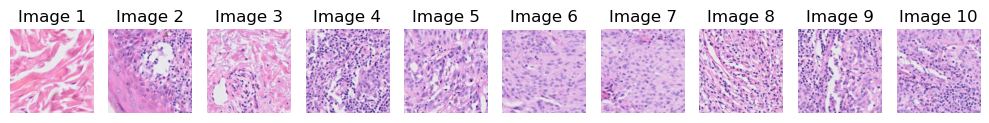

Number of images: 10
Total tokens per batch: 3092

Batch #2
Prompt: Generate accurate descriptions capturing the morphological features in the attached images from this directory: transfered_Xeniumranger_V1_hSkin_Melanoma_Add_on_FFPE_he_image.ome.


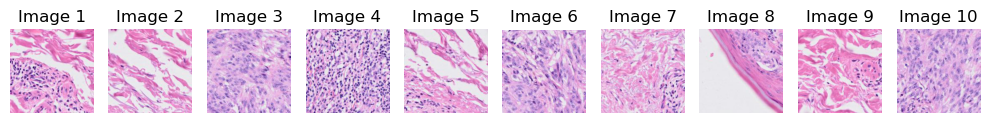

Number of images: 10


KeyboardInterrupt: 

In [62]:
responses = []
token_counts = []
for idx, batch in enumerate(batches):
    print(f"\nBatch #{idx+1}")
    show_batch(batch)

    response = batch_llm_request(client, system_prompt, batch[0], batch[1])
    responses.append(response)
    total_tokens = response.usage.total_tokens
    print("Total tokens per batch:", total_tokens)
    token_counts.append(total_tokens)

In [14]:
text_responses = [response.choices[0].message.content for response in responses]
llm_outputs = ' '.join(text_responses)
#outputs = [x for x in re.split(r'###|\d+\.', llm_outputs) if x.strip()]
#text_responses = [x for x in re.split(r'\n\n', llm_outputs) if x.strip()]
#text_responses = [x for x in re.split(r'\d+', llm_outputs) if x.strip()]
outputs = []
for text_resp in text_responses:
    indiv = [x.strip() for x in re.split(r'\d+', text_resp) if len(x) > 10]
    outputs += indiv    
        
#outputs

In [15]:
# Define CSV file path
csv_filename = f"Captions/captions_{num_batches}b_{batch_size}sz_{start_dir_idx}-{end_dir_idx-1}_dirs.csv"

# Identify rows to be removed (indices of captions that contain "unable" or "blank")
rows_to_be_removed = [i for i, resp in enumerate(outputs) if "unable" in resp or "blank" in resp]

# Extract valid captions (removing those in `rows_to_be_removed`)
captions = [resp for i, resp in enumerate(outputs) if i not in rows_to_be_removed]

# Flatten image_dict to [(directory, image), ...]
image_list = [(directory, image) for directory, images in image_dict.items() for image in images]

# Filter images based on the same indices in `rows_to_be_removed`
filtered_image_list = [img for i, img in enumerate(image_list) if i not in rows_to_be_removed]

# Ensure there are enough captions for the images
num_images = len(filtered_image_list)
num_captions = len(captions)

print("  # of images:", num_images)
print("# of captions:", num_captions)

if num_captions < num_images:
    print(f"Warning: Fewer captions ({num_captions}) than images ({num_images}). Some images will be left without captions.")
elif num_captions > num_images:
    print(f"Warning: More captions ({num_captions}) than images ({num_images}). Some captions will be unused.")


# Ensure both lists have the same length by truncating to the minimum size
min_length = min(len(filtered_image_list), len(captions))
filtered_image_list = filtered_image_list[:min_length]
captions = captions[:min_length]

# Pair filtered images with captions
paired_data = [
    (dir_dict[directory], image.split("/")[-1], captions[i])
    for i, (directory, image) in enumerate(filtered_image_list)
]

# Write to CSV
with open(csv_filename, mode="w", newline="", encoding="utf-8") as file:
    writer = csv.writer(file)
    writer.writerow(["Directory_Name", "Patch_Name", "Caption"])  # Header
    writer.writerows(paired_data)

print(f"Data saved to {csv_filename}")

  # of images: 498
# of captions: 498
Data saved to Captions/captions_50b_10sz_20-29_dirs.csv
